In [1]:
from google.cloud import bigquery
import pandas as pd
import numpy as np
import seaborn as sns
import datetime 
from datetime import date
from datetime import *; from dateutil.relativedelta import *
from datetime import datetime
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import summary_table

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.9f' % x)
np.set_printoptions(suppress=True)

In [2]:
import pydata_google_auth
credentials = pydata_google_auth.get_user_credentials(
    ['https://www.googleapis.com/auth/bigquery'],
)

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=262006177488-3425ks60hkk80fssi9vpohv88g6q1iqd.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A8080%2F&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fbigquery&state=1Y37s3XTNhsZcHV5HPU2HYFvh67H5g&access_type=offline


In [3]:
client = bigquery.Client(project = 'etsy-bigquery-adhoc-prod', credentials=credentials)

In [13]:
# #update to fb prophet 

# # create timeseries readable by fbprophet
# ts = pd.DataFrame({'ds':base_yoy.index,'y':base_yoy.chargeability})

# from fbprophet import Prophet

# # instantiate the model and fit the timeseries
# prophet = Prophet()
# prophet.fit(ts)


from statsmodels.tsa.arima.model import ARIMA

for i in df['reporting_channel_group_engine'].drop_duplicates().values.tolist():

    timeseries = df.loc[(df['reporting_channel_group_engine'] == i)&(df['order_date'] >= '2022-01-01')&(df['order_date'] < '2022-06-01'),['order_date','chargeability']].copy(deep=True)

    timeseries.set_index('order_date', inplace=True)

    timeseries.index = timeseries.index.to_period('W')

    timeseries.sort_index(inplace=True)

    train = timeseries[:int(len(timeseries)*.75)]
    test = timeseries[int(len(timeseries)*.75):]

    # fit model
    model = ARIMA(train, order=(1, 1, 1))  
    fitted = model.fit() 
    
    print(i)
    result = fitted.get_forecast()
    # summarize forecast and confidence intervals
    print('Expected: %.3f' % result.predicted_mean)
    #print('Forecast: %.3f' % test[0])
    print('Standard Error: %.3f' % result.se_mean)
    ci = result.conf_int(0.05)
    print(ci)
    #print('95%% Interval: %.3f to %.3f' % (ci[0,0], ci[0,1]))

PLA - Google - Paid
Expected: 0.565
Standard Error: 0.005
                       lower chargeability  upper chargeability
2022-04-18/2022-04-24             0.554624             0.575344
Affiliates - Affiliates
Expected: 0.004
Standard Error: 0.001
                       lower chargeability  upper chargeability
2022-04-18/2022-04-24             0.001936             0.005174
PLA - Bing - Paid
Expected: 0.555
Standard Error: 0.017
                       lower chargeability  upper chargeability
2022-04-18/2022-04-24             0.521585             0.588584
Display - Google - Paid
Expected: 0.142
Standard Error: 0.023
                       lower chargeability  upper chargeability
2022-04-18/2022-04-24             0.097165             0.186885
Paid Social - Facebook - Paid
Expected: 0.454
Standard Error: 0.016
                       lower chargeability  upper chargeability
2022-04-18/2022-04-24             0.421768             0.486078
Paid Social - Pinterest - Paid
Expected: 0.354
Standar

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [4]:
#add code for `etsy-data-warehouse-dev.tnormil.offsite_ads_chargeability` 
#data last updated on 08/04/2022


# sql = """
# with base as
#         (select order_date,
#                 top_channel,
#                 second_channel,
#                 #third_channel,
#                 #utm_campaign,
#                 #utm_medium,
#                 mapped_region,
#       sum(attr_gms) AS attr_gms,
#       sum(attr_receipt) as attr_receipt,
#       #sum(attr_rev) as attr_rev,
#       sum(chargeable_attr_gms) as chargeable_attr_gms,
#       sum(chargeable_attr_receipt) as chargeable_attr_receipt,
#       #sum(chargeable_attr_rev) as chargeable_attr_rev,
#       sum(chargeable_gms) as chargeable_gms,
#       sum(chargeable_receipts) as chargeable_receipts,
#       sum(advertising_revenue) as advertising_revenue
#       from `etsy-data-warehouse-dev.tnormil.offsite_ads_chargeability` 
#       group by 1,2,3,4)
# SELECT * EXCEPT (order_date) ,
# '' as flag,
# order_date
# FROM base osa
# UNION ALL
# SELECT * EXCEPT (order_date) ,
# '_dly' as flag,
# datetime_add(osa.order_date, interval 52 WEEK) AS order_date,
# FROM base osa
# WHERE datetime_add(order_date, interval 52 WEEK) < CAST(current_date() as DATETIME)
# union all
# SELECT * EXCEPT (order_date) ,
# '_d2ly' as flag,
# datetime_add(osa.order_date, interval 104 WEEK) AS order_date,
# FROM base osa
# WHERE datetime_add(order_date, interval 104 WEEK) < CAST(current_date() as DATETIME)
# union all
# SELECT * EXCEPT (order_date) ,
# '_d3ly' as flag,
# datetime_add(osa.order_date, interval 156 WEEK) AS order_date,
# FROM base osa
# WHERE datetime_add(order_date, interval 156 WEEK) < CAST(current_date() as DATETIME)
# """

sql = """
with base as
        (select order_date,
        date_trunc(order_date, year) as order_year, 
        extract(week from order_date) as order_week_num, 
        extract(dayofyear from order_date) as order_dayofyear, 
        reporting_channel_group,
        engine,
      sum(attr_gms) AS attr_gms,
      sum(attr_receipt) as attr_receipt,
      sum(attr_rev) as attr_rev,
      sum(chargeable_attr_gms) as chargeable_attr_gms,
      sum(chargeable_attr_receipt) as chargeable_attr_receipt,
      sum(chargeable_attr_rev) as chargeable_attr_rev,
      sum(chargeable_gms) as chargeable_gms,
      sum(chargeable_receipts) as chargeable_receipts,
      sum(advertising_revenue) as advertising_revenue
      from `etsy-data-warehouse-dev.tnormil.offsite_ads_chargeability` 
      left join `etsy-data-warehouse-prod.buyatt_mart.channel_dimensions` cd using (utm_campaign, utm_medium, top_channel, second_channel, third_channel)
      where order_date <= '2022-07-01'
      group by 1,2,3,4,5,6)
SELECT * EXCEPT (order_date) ,
'' as flag,
order_date
FROM base osa
UNION ALL
SELECT * EXCEPT (order_date) ,
'_dly' as flag,
datetime_add(osa.order_date, interval 52 WEEK) AS order_date,
FROM base osa
WHERE datetime_add(order_date, interval 52 WEEK) < CAST(current_date() as DATETIME)
union all
SELECT * EXCEPT (order_date) ,
'_d2ly' as flag,
datetime_add(osa.order_date, interval 104 WEEK) AS order_date,
FROM base osa
WHERE datetime_add(order_date, interval 104 WEEK) < CAST(current_date() as DATETIME)
union all
SELECT * EXCEPT (order_date) ,
'_d3ly' as flag,
datetime_add(osa.order_date, interval 156 WEEK) AS order_date,
FROM base osa
WHERE datetime_add(order_date, interval 156 WEEK) < CAST(current_date() as DATETIME)
"""

query_job = client.query(sql)
results = query_job.result()
base = results.to_dataframe()

In [20]:
base.head()

,order_year,order_week_num,order_dayofyear,reporting_channel_group,engine,attr_gms,attr_receipt,attr_rev,chargeable_attr_gms,chargeable_attr_receipt,chargeable_attr_rev,chargeable_gms,chargeable_receipts,advertising_revenue,flag,order_date
0,2020-01-01,16,110,PLA,Google - Paid,4827926.752507780,161714.499907169,808553.656633318,2091910.064160483,64048.294812953,228494.699318930,3059193.600000000,351478,438631.500000000,_d2ly,2022-04-17
1,2020-01-01,21,149,PLA,Google - Paid,4282455.049740183,147255.719553354,924094.408867824,1567574.339367565,48714.783702342,288264.299955321,2491490.320000000,354951,358012.720000000,_d2ly,2022-05-26
2,2020-01-01,13,89,PLA,Google - Paid,1963722.768266225,65787.150800070,328634.629612777,887405.549866211,28211.868559938,109124.689082145,1302554.730000000,121849,188422.750000000,_d2ly,2022-03-27
3,2020-01-01,21,151,PLA,Bing - Paid,188246.908341848,6949.288696345,43964.475963381,59971.107114177,1999.005308182,15504.829755993,89744.600000000,7956,13241.400000000,_d2ly,2022-05-28
4,2020-01-01,25,177,PLA,Bing - Paid,169900.304817327,6544.807895964,40522.651692656,56058.753048701,1924.841464067,14975.808970010,83572.720000000,6446,12062.250000000,_d2ly,2022-06-23


In [117]:
base ['reporting_channel_group_engine'] = base['reporting_channel_group'] + ' - ' + base['engine']
new_base = pd.concat( [base[['order_date','flag', 'reporting_channel_group_engine']], base.drop(columns=['order_date','flag', 'reporting_channel_group_engine'])], axis = 1)

In [22]:
new_base.dtypes

order_date                        datetime64[ns]
flag                                      object
reporting_channel_group_engine            object
order_year                                dbdate
order_week_num                             Int64
order_dayofyear                            Int64
reporting_channel_group                   object
engine                                    object
attr_gms                                  object
attr_receipt                             float64
attr_rev                                  object
chargeable_attr_gms                       object
chargeable_attr_receipt                  float64
chargeable_attr_rev                       object
chargeable_gms                            object
chargeable_receipts                        Int64
advertising_revenue                      float64
dtype: object

In [118]:
metrics_index = (new_base.columns.values.tolist()).index("attr_gms")
group_by_col = (new_base.columns.values.tolist())[:metrics_index ]
metrics = (new_base.columns.values.tolist())[metrics_index:]

print(group_by_col)
print(metrics)

['order_date', 'flag', 'reporting_channel_group_engine', 'order_year', 'order_week_num', 'order_dayofyear', 'reporting_channel_group', 'engine']
['attr_gms', 'attr_receipt', 'attr_rev', 'chargeable_attr_gms', 'chargeable_attr_receipt', 'chargeable_attr_rev', 'chargeable_gms', 'chargeable_receipts', 'advertising_revenue']


In [119]:
new_base[metrics] = new_base[metrics].astype(float)

new_base['chargeability'] = (new_base['chargeable_gms']/new_base['attr_gms'] * 100).astype(float)
new_base['aov'] = (new_base['attr_gms']/new_base['attr_receipt']).astype(float) 
new_base['chargeable_aov'] = (new_base['chargeable_gms']/new_base['chargeable_attr_receipt']).astype(float)

In [103]:
new_base.head()

,order_date,flag,reporting_channel_group_engine,order_year,order_week_num,order_dayofyear,reporting_channel_group,engine,attr_gms,attr_receipt,attr_rev,chargeable_attr_gms,chargeable_attr_receipt,chargeable_attr_rev,chargeable_gms,chargeable_receipts,advertising_revenue,chargeability,aov,chargeable_aov
0,2022-04-17,_d2ly,PLA - Google - Paid,2020-01-01,16,110,PLA,Google - Paid,4827926.752507780,161714.499907169,808553.656633318,2091910.064160483,64048.294812953,228494.699318930,3059193.600000000,351478.000000000,438631.500000000,0.633645405,29.854631188,47.763857085
1,2022-05-26,_d2ly,PLA - Google - Paid,2020-01-01,21,149,PLA,Google - Paid,4282455.049740183,147255.719553354,924094.408867824,1567574.339367565,48714.783702342,288264.299955321,2491490.320000000,354951.000000000,358012.720000000,0.581790186,29.081756978,51.144439750
2,2022-03-27,_d2ly,PLA - Google - Paid,2020-01-01,13,89,PLA,Google - Paid,1963722.768266225,65787.150800070,328634.629612777,887405.549866211,28211.868559938,109124.689082145,1302554.730000000,121849.000000000,188422.750000000,0.663308870,29.849640004,46.170452242
3,2022-05-28,_d2ly,PLA - Bing - Paid,2020-01-01,21,151,PLA,Bing - Paid,188246.908341848,6949.288696345,43964.475963381,59971.107114177,1999.005308182,15504.829755993,89744.600000000,7956.000000000,13241.400000000,0.476738772,27.088658504,44.894628160
4,2022-06-23,_d2ly,PLA - Bing - Paid,2020-01-01,25,177,PLA,Bing - Paid,169900.304817327,6544.807895964,40522.651692656,56058.753048701,1924.841464067,14975.808970010,83572.720000000,6446.000000000,12062.250000000,0.491892702,25.959555654,43.417975745


In [120]:
metrics = (new_base.columns.values.tolist())[metrics_index:]

base_yoy = new_base[new_base['flag'] == ''].copy()

for i in new_base['flag'].drop_duplicates():
    
    print(i)
    
    if i != '':
        
        join_df = new_base[new_base['flag'] == i]
        join_df.columns = group_by_col + [item + i for item in metrics]
        
        base_yoy = base_yoy.merge(join_df.loc[:, ~join_df.columns.isin(['flag','order_weeknum','order_year','order_dayofyear'])], how='left', 
        on=[ item for item in group_by_col if item not in ['flag','order_weeknum','order_year','order_dayofyear'] ])
        
        base_yoy['aov' + i + '_yoy'] = (base_yoy['aov']/base_yoy['aov' + i] * 100).astype(float) 
        base_yoy['chargeable_aov' + i + '_yoy'] = (base_yoy['chargeable_aov']/base_yoy['chargeable_aov' + i ] * 100).astype(float) 
           
    else:
        
        continue

base_yoy.drop(columns=['flag'], inplace=True)

_d2ly
_dly



In [105]:
base_yoy[base_yoy['order_date']=='2022-06-01'].head()

,order_date,reporting_channel_group_engine,order_year,order_week_num,order_dayofyear,reporting_channel_group,engine,attr_gms,attr_receipt,attr_rev,chargeable_attr_gms,chargeable_attr_receipt,chargeable_attr_rev,chargeable_gms,chargeable_receipts,advertising_revenue,chargeability,aov,chargeable_aov,attr_gms_d2ly,attr_receipt_d2ly,attr_rev_d2ly,chargeable_attr_gms_d2ly,chargeable_attr_receipt_d2ly,chargeable_attr_rev_d2ly,chargeable_gms_d2ly,chargeable_receipts_d2ly,advertising_revenue_d2ly,chargeability_d2ly,aov_d2ly,chargeable_aov_d2ly,aov_d2ly_yoy,chargeable_aov_d2ly_yoy,attr_gms_dly,attr_receipt_dly,attr_rev_dly,chargeable_attr_gms_dly,chargeable_attr_receipt_dly,chargeable_attr_rev_dly,chargeable_gms_dly,chargeable_receipts_dly,advertising_revenue_dly,chargeability_dly,aov_dly,chargeable_aov_dly,aov_dly_yoy,chargeable_aov_dly_yoy
1098,2022-06-01,NaN,2022-01-01,22,152,None,None,389204.569374484,11318.853891465,67624.493271322,111.208516457,3.437378469,44.366607167,409.390000000,7.000000000,53.150000000,0.001051863,34.385510504,119.099483430,363135.254634504,13147.433471245,62691.484678251,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,27.620238994,NaN,124.493892001,NaN,352541.271384162,10108.426206083,53522.634329976,570.781070631,9.407465647,139.806874684,1221.390000000,20.000000000,158.490000000,0.003464531,34.875980118,129.831991513,98.593675038,91.733541203
2752,2022-06-01,Paid Social - Pinterest - Paid,2022-01-01,22,152,Paid Social,Pinterest - Paid,37641.407745174,1332.277181945,7041.691234466,7220.187326455,184.961036827,1781.061875553,15541.300000000,845.000000000,1831.140000000,0.412877757,28.253435738,84.024723621,3602.488529388,100.645103035,716.800899091,1245.936689572,22.238222967,279.701559713,4267.000000000,117.000000000,539.150000000,1.184459011,35.793977260,191.876842239,78.933490773,43.790966456,6389.521516954,202.575273274,1183.872389302,1857.889394527,44.904565033,450.501947255,6188.520000000,174.000000000,728.310000000,0.968542008,31.541468086,137.814941432,89.575525340,60.969240888
3222,2022-06-01,Affiliates - Affiliates,2022-01-01,22,152,Affiliates,Affiliates,3.453968889,0.042474480,0.397126951,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,81.318684844,NaN,134.911779853,3.426274468,20.374247132,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,39.375648720,NaN,206.520241542,NaN,1.920076503,0.094314154,0.334823403,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,20.358306949,NaN,399.437365052,NaN
3305,2022-06-01,Display - Google - Paid,2022-01-01,22,152,Display,Google - Paid,49145.779370250,1490.316779301,9292.569002242,1833.563642125,46.948004094,529.116524789,4882.190000000,194.000000000,642.190000000,0.099340982,32.976733573,103.991428266,7831.063595993,307.583629870,1348.871195908,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,25.459949215,NaN,129.523956603,NaN,49481.439330201,1282.717466085,9108.326629955,9513.239005262,162.592283022,1659.985350224,41554.220000000,1412.000000000,4888.950000000,0.839794084,38.575477951,255.573138082,85.486260507,40.689498531
3754,2022-06-01,Paid Social - Facebook - Paid,2022-01-01,22,152,Paid Social,Facebook - Paid,188505.962488599,5777.078136650,33944.568687500,42702.308298887,949.292805788,8912.674136073,85399.770000000,4808.000000000,10823.150000000,0.453034848,32.629983190,89.961463396,165282.950655910,5287.731002503,23997.452259065,5996.425675473,107.668035301,890.360824502,17298.400000000,758.000000000,2057.720000000,0.104659313,31.257821281,160.664211543,104.389819423,55.993467700,325307.065512500,9698.589119880,52386.855787661,54720.780803711,1044.294283273,9904.980168608,77520.100000000,3803.000000000,9831.950000000,0.238298236,33.541689569,74.232044781,97.281871039,121.189526251


In [121]:
base_yoy['order_date'] = pd.to_datetime(base_yoy['order_date']).dt.date
base_yoy['order_year'] = pd.to_datetime(base_yoy['order_year']).dt.date

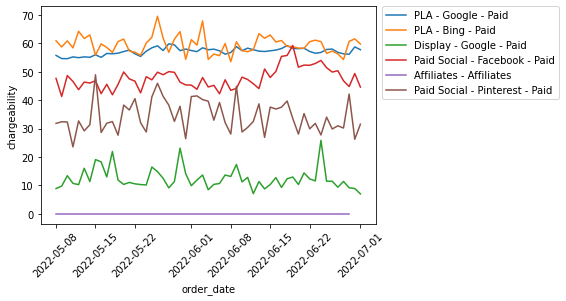

In [122]:
viz_data = base_yoy[(base_yoy['reporting_channel_group'] != "Other Paid")&(base_yoy['engine'] != "Other Paid")]

_ = sns.lineplot(data=viz_data[viz_data['order_date']>= date.today() - relativedelta(months=3)], x="order_date", y="chargeability",hue='reporting_channel_group_engine')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

In [108]:
base_yoy.head()

,order_date,reporting_channel_group_engine,order_year,order_week_num,order_dayofyear,reporting_channel_group,engine,attr_gms,attr_receipt,attr_rev,chargeable_attr_gms,chargeable_attr_receipt,chargeable_attr_rev,chargeable_gms,chargeable_receipts,advertising_revenue,chargeability,aov,chargeable_aov,attr_gms_d2ly,attr_receipt_d2ly,attr_rev_d2ly,chargeable_attr_gms_d2ly,chargeable_attr_receipt_d2ly,chargeable_attr_rev_d2ly,chargeable_gms_d2ly,chargeable_receipts_d2ly,advertising_revenue_d2ly,chargeability_d2ly,aov_d2ly,chargeable_aov_d2ly,aov_d2ly_yoy,chargeable_aov_d2ly_yoy,attr_gms_dly,attr_receipt_dly,attr_rev_dly,chargeable_attr_gms_dly,chargeable_attr_receipt_dly,chargeable_attr_rev_dly,chargeable_gms_dly,chargeable_receipts_dly,advertising_revenue_dly,chargeability_dly,aov_dly,chargeable_aov_dly,aov_dly_yoy,chargeable_aov_dly_yoy
0,2022-01-08,PLA - Google - Paid,2022-01-01,1,8,PLA,Google - Paid,4674486.001851322,144004.969497693,960500.854325756,1651969.783510719,45612.716287872,307062.592505705,2668512.400000000,288358.000000000,361716.960000000,0.570867556,32.460588118,58.503694083,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5001097.215806957,156775.552846867,1037534.342620787,1882269.645139733,51018.486166115,328818.543260007,2974499.890000000,308289.000000000,402768.570000000,0.594769460,31.899726233,58.302394162,101.758202818,100.345268705
1,2020-10-14,PLA - Google - Paid,2020-01-01,41,288,PLA,Google - Paid,3765941.563998059,123026.754239504,805697.533942146,1462358.665257678,41962.843753629,282020.323530207,2232518.900000000,230767.000000000,304034.240000000,0.592818253,30.610752818,53.202278499,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-09-13,PLA - Google - Paid,2020-01-01,37,257,PLA,Google - Paid,4290337.164854595,137890.518672850,907525.631920747,1644758.537488386,46978.096026973,297913.949140653,2550961.600000000,316921.000000000,353097.760000000,0.594583013,31.114083884,54.301085309,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-08-03,PLA - Google - Paid,2020-01-01,31,216,PLA,Google - Paid,3818589.773507178,125962.747822959,820645.841877648,1377527.491941332,40363.264963372,259765.697896555,2258836.740000000,275052.000000000,310035.150000000,0.591536896,30.315230808,55.962686419,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-06-01,PLA - Google - Paid,2020-01-01,22,153,PLA,Google - Paid,3867236.191598817,134133.525270018,833825.120416374,1429148.362874644,45397.019332008,266974.782180150,2278015.980000000,308904.000000000,320274.330000000,0.589055301,28.831242479,50.179857918,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [123]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
    
metrics_index = (base_yoy.columns.values.tolist()).index("attr_gms")
group_by_col = (base_yoy.columns.values.tolist())[:metrics_index ]
exclude_col = ['order_date','order_year','reporting_channel_group_engine', 'reporting_channel_group', 'engine']
channel = ['Paid Social - Facebook - Paid','PLA - Google - Paid','PLA - Bing - Paid']
exclude_dates = [date(2021, 12, 31)]

#get metrics with yoy stats
metrics = ['chargeable_aov','aov','attr_gms']

#dupe_model_features = [item for item in base_yoy.columns.values.tolist() if any(xs in item for xs in dupe_metrics)]

model_features = [item for item in base_yoy.columns.values.tolist() if item.startswith(tuple(metrics))]

#get model data: data from the past 12 months from OSA channels

model_base = base_yoy.loc[(base_yoy['order_date'] >= date.today() - relativedelta(months=12))&(base_yoy['reporting_channel_group_engine'].isin(channel)&(base_yoy['order_year'] != '0')), group_by_col + model_features + ['chargeability']]

model_base = model_base[~model_base.order_date.isin(exclude_dates)]

model_base.fillna(0, inplace= True)

#one hot encode categorical variables 
dummy_results = pd.get_dummies(model_base[['order_year','reporting_channel_group_engine']])

model_base = pd.concat([model_base,dummy_results], axis = 1)

#set columns to be excluded from training data to index
model_base.set_index(exclude_col,inplace=True)

In [62]:
model_base.head()

,,,,,order_week_num,order_dayofyear,attr_gms,aov,chargeable_aov,attr_gms_d2ly,aov_d2ly,chargeable_aov_d2ly,aov_d2ly_yoy,chargeable_aov_d2ly_yoy,attr_gms_dly,aov_dly,chargeable_aov_dly,aov_dly_yoy,chargeable_aov_dly_yoy,chargeability,order_year_2021-01-01,order_year_2022-01-01,reporting_channel_group_engine_PLA - Bing - Paid,reporting_channel_group_engine_PLA - Google - Paid,reporting_channel_group_engine_Paid Social - Facebook - Paid
order_date,order_year,reporting_channel_group_engine,reporting_channel_group,engine,,,,,,,,,,,,,,,,,,,,,
2022-01-08,2022-01-01,PLA - Google - Paid,PLA,Google - Paid,1,8,4674486.001851322,32.460588118,58.503694083,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,5001097.215806957,31.899726233,58.302394162,1.017582028,1.003452687,0.570867556,0,1,0,1,0
2022-03-06,2022-01-01,PLA - Google - Paid,PLA,Google - Paid,10,65,5253314.271196630,32.201343219,56.487642286,1415614.433598397,31.609500626,52.135303582,1.018723567,1.083481603,5354750.963168385,33.160825627,60.358563671,0.971065787,0.935867901,0.561614499,0,1,0,1,0
2022-04-25,2022-01-01,PLA - Google - Paid,PLA,Google - Paid,17,115,4756833.212134641,33.012306374,56.933710640,5072095.078327410,28.929966735,47.078835967,1.141111107,1.209327067,5309942.215329084,34.900809022,65.348812610,0.945889431,0.871227928,0.558229596,0,1,0,1,0
2022-06-17,2022-01-01,PLA - Google - Paid,PLA,Google - Paid,24,168,3212382.849737347,30.845593537,55.687317311,3601834.927569107,28.637566137,52.152127055,1.077102481,1.067786118,3492042.455088808,32.118966058,59.810944065,0.960354498,0.931055648,0.581592717,0,1,0,1,0
2021-12-12,2021-01-01,PLA - Google - Paid,PLA,Google - Paid,50,346,7809576.756032207,29.687355401,52.571581730,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,9333145.452090517,30.690421171,54.288604563,0.967316650,0.968372316,0.534657726,1,0,0,1,0


In [63]:
print(model_base.sum())

order_week_num                                                      25659.000000000
order_dayofyear                                                    178074.000000000
attr_gms                                                       1699491310.982700586
aov                                                                 31449.999867114
chargeable_aov                                                      65140.631171748
attr_gms_d2ly                                                   529364812.897135854
aov_d2ly                                                            14037.002065778
chargeable_aov_d2ly                                                 25830.598977310
aov_d2ly_yoy                                                          472.195455514
chargeable_aov_d2ly_yoy                                               544.874537854
attr_gms_dly                                                   1789571963.987813950
aov_dly                                                             31083.09

In [124]:
x_train,x_test,y_train,y_test=train_test_split(model_base.loc[:,model_base.columns != 'chargeability'],model_base['chargeability'],test_size=0.2,random_state=0)

In [143]:
linreg=LinearRegression()
linreg.fit(x_train,y_train)
y_pred=linreg.predict(x_test)

print('Coefficients: ', linreg.coef_)
  
print('Variance score: {}'.format(linreg.score(x_test, y_test)))

feature_importance = pd.DataFrame(zip(np.array([item for item in model_base.columns.values if item != 'chargeability']) , linreg.coef_), columns=['Feature','Coefficient'])

print(feature_importance )

Coefficients:  [ -1.40199638   0.20180172  -0.00000134   3.21183255   0.19180888
  -0.00000031  -0.1797472    0.09805424  -0.09791345   0.09575643
   0.00000028  -2.94701607  -0.01386271  -0.63466321  -0.17759562
  -1.23587418   1.23587418   4.79218961   7.54627663 -12.33846623]
Variance score: 0.7801767151560595
                                              Feature   Coefficient
0                                      order_week_num  -1.401996382
1                                     order_dayofyear   0.201801722
2                                            attr_gms  -0.000001339
3                                                 aov   3.211832552
4                                      chargeable_aov   0.191808879
5                                       attr_gms_d2ly  -0.000000305
6                                            aov_d2ly  -0.179747197
7                                 chargeable_aov_d2ly   0.098054241
8                                        aov_d2ly_yoy  -0.097913452
9    

In [144]:
R2 = r2_score(y_test, y_pred)
MAE = mean_absolute_error(y_test, y_pred)
RSME = mean_squared_error(y_test, y_pred)

print('R2: {}'.format(R2))
print('MAE: {}'.format(MAE))
print('RSME: {}'.format(RSME))

R2: 0.7801767151560595
MAE: 2.536956837014898
RSME: 11.257399992681984


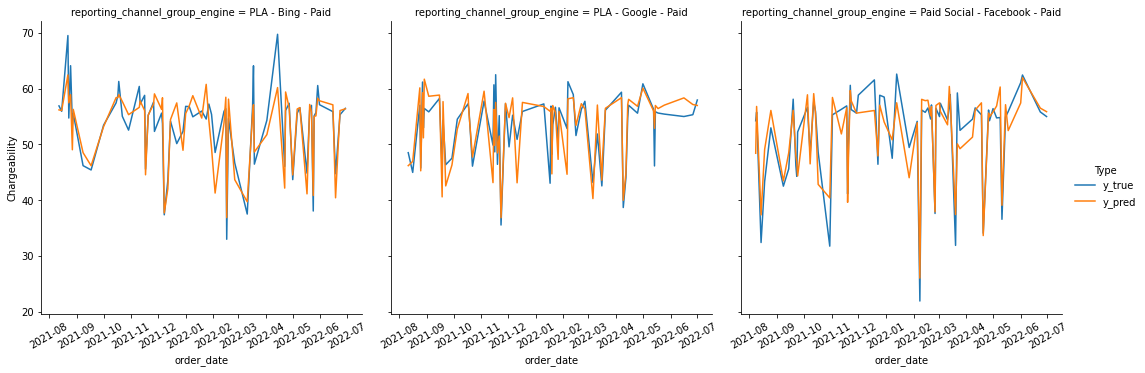

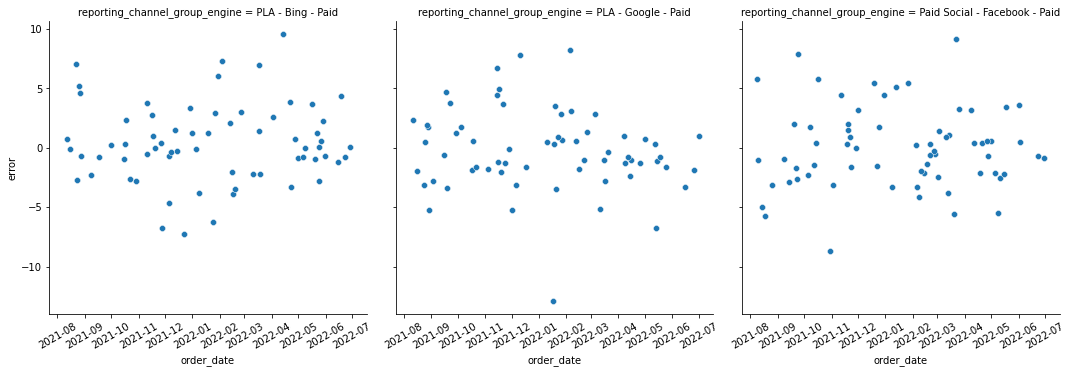

In [164]:
result = pd.DataFrame(zip(y_test,y_pred), columns = ['y_true','y_pred'])

result['error'] = (result['y_true'] - result['y_pred'])

viz_result = pd.concat([x_train.reset_index(), result] ,axis = 1)

viz_result_pivot = pd.melt(viz_result,
    id_vars=[item for item in viz_result.columns if item not in ['y_true','y_pred']], 
    var_name="Type", value_name="Chargeability")

#sns.lineplot(data=viz_result_pivot, x="order_date", y="Value", hue="Type", col="reporting_channel_group_engine")

viz = sns.relplot(
    data=viz_result_pivot, x="order_date", y="Chargeability",
    col="reporting_channel_group_engine", hue="Type", kind="line"
)

viz.set_xticklabels(rotation=30)

viz2 = sns.relplot(
    data=viz_result_pivot, x="order_date", y="error",
    col="reporting_channel_group_engine"
)

viz2.set_xticklabels(rotation=30)


In [161]:
viz_result.head()

,order_date,order_year,reporting_channel_group_engine,reporting_channel_group,engine,order_week_num,order_dayofyear,attr_gms,aov,chargeable_aov,attr_gms_d2ly,aov_d2ly,chargeable_aov_d2ly,aov_d2ly_yoy,chargeable_aov_d2ly_yoy,attr_gms_dly,aov_dly,chargeable_aov_dly,aov_dly_yoy,chargeable_aov_dly_yoy,order_year_2021-01-01,order_year_2022-01-01,reporting_channel_group_engine_PLA - Bing - Paid,reporting_channel_group_engine_PLA - Google - Paid,reporting_channel_group_engine_Paid Social - Facebook - Paid,y_true,y_pred,mse
0,2022-06-18,2022-01-01,PLA - Bing - Paid,PLA,Bing - Paid,24,169,115712.761832345,27.635404959,55.025183896,155663.700526644,26.826074306,54.474418927,103.016955234,101.011052491,164025.034010913,30.714803563,60.656231744,89.974220091,90.716456190,0,1,1,0,0,44.765984005,40.444775782,11.257399993
1,2022-02-06,2022-01-01,PLA - Google - Paid,PLA,Google - Paid,6,37,5765168.502283371,31.470900073,55.361796179,1720090.261235892,30.287194339,48.820611051,103.908271333,113.398408965,5955294.109889421,31.097893650,57.353148589,101.199458804,96.527910917,0,1,0,1,0,61.245798475,58.178201717,11.257399993
2,2022-02-26,2022-01-01,Paid Social - Facebook - Paid,Paid Social,Facebook - Paid,8,57,361832.241660313,33.414921157,80.105030790,175696.927410330,40.566835853,74.598271607,82.370045516,107.381885752,527341.434843664,32.739982118,72.659026321,102.061513156,110.247872626,0,1,0,0,1,56.459330957,56.988793741,11.257399993
3,2022-02-17,2022-01-01,Paid Social - Facebook - Paid,Paid Social,Facebook - Paid,7,48,296197.501120908,34.295262510,79.429246529,157701.164093235,42.276440700,81.173321398,81.121451906,97.851418620,447754.812129615,32.558866465,83.090019420,105.333097351,95.594208647,0,1,0,0,1,56.537404425,57.926830710,11.257399993
4,2022-01-19,2022-01-01,PLA - Bing - Paid,PLA,Bing - Paid,3,19,207690.162344753,31.796453222,59.516959284,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,222167.575211505,29.012356836,54.079511543,109.596243430,110.054542999,0,1,1,0,0,55.981891877,54.733892109,11.257399993


In [ ]:
plt.scatter(y_test,y_pred)
plt.xlabel('Actual values')
plt.ylabel('Predicted values')

plt.plot(np.unique(y_test), np.poly1d(np.polyfit(y_test, y_pred, 1))(np.unique(y_test)))

plt.text(0.6, 0.5, 'R-squared = %0.2f' % R2)
plt.show()

In [125]:
import statsmodels.api as sm
from scipy import stats

X2 = sm.add_constant(np.asarray(x_train.astype(int)))
est = sm.OLS(np.asarray(y_train.astype(int)), X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.774
Model:                            OLS   Adj. R-squared:                  0.769
Method:                 Least Squares   F-statistic:                     145.7
Date:                Mon, 08 Aug 2022   Prob (F-statistic):          1.03e-232
Time:                        16:23:33   Log-Likelihood:                -2143.3
No. Observations:                 784   AIC:                             4325.
Df Residuals:                     765   BIC:                             4413.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         24.8708      6.768      3.675      0.0

In [ ]:
new_base.to_csv('historical_osa_chargeability.csv')